In [41]:
#Import libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
import random as rn

from tqdm import tqdm
from random import shuffle  
from zipfile import ZipFile
from PIL import Image
from skimage import feature, color, data
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.svm import LinearSVC

In [42]:
#Import Training & test gambar
#training set
train_path = "train/"

#testing set
test_path = "test/"

#membuat 2 set array untuk train dan testing data

X_train =[] #menyimpan data hog training gambar 
label_train = [] #menyimpan label gambar training

X_test = [] #menyimpan data hog testing gambar
label_test = [] # #menyimpan label gambar testing

scene_label=['mask','non_mask']#mendefinisikan label

In [43]:
#"hog_data_extractor" fungsi akan mendapatkan fitur hog dari file png
def hog_data_extractor(png_path):
    png_data = cv2.imread(png_path)
    png_data= cv2.resize(png_data,(150,150))
    png_data= cv2.cvtColor(png_data,cv2.COLOR_BGR2GRAY) 
    hog_data = feature.hog(png_data)/255.0
    return hog_data

In [44]:
#"png_to_array" fungsi akan memuat gambar dari jalur path yang diberikan dan menyimpan fitur hog ke dalam X_train_data & X_test_data masing-masing
def png_to_array (scene_type, img_root_path,data_type):
    scene_path = os.path.join(img_root_path,scene_type.lower())
    print('Loading ' + data_type +' images for scene type '+scene_type)
    for img in os.listdir(scene_path):
        img_path = os.path.join(scene_path,img)
        if img_path.endswith('.png'):
            if(data_type == 'Training'):
                X_train.append(hog_data_extractor(img_path))
                label_train.append(str(scene_type))
            if(data_type =='Testing'):
                X_test.append(hog_data_extractor(img_path))
                label_test.append(np.array(str(scene_type)))

In [45]:
#Panggil fungsi "jpeg_to_array" untuk memuat gambar pelatihan & pengujian
[png_to_array(scene,train_path,'Training')for scene in scene_label]
len(X_train)
[png_to_array(scene,test_path,'Testing')for scene in scene_label]
len(X_test)

Loading Training images for scene type mask
Loading Training images for scene type non_mask
Loading Testing images for scene type mask
Loading Testing images for scene type non_mask


100

In [46]:
#menggunakan label encoder untuk meng encode scene_label
le = LabelEncoder()#mengubah label kategori menjadi nilai numerik
#menighitung nilai data dan lakukan transformasi(mengisi nilai kosong)
y_train = le.fit_transform(label_train)
y_test = le.fit_transform(label_test)

In [47]:
#Buat model SVM Linear dan latih
lsvc = LinearSVC(random_state=0,tol=1e-5)
lsvc.fit(X_train,y_train)
print('Coef : ',lsvc.coef_)
print('Intercept : ',lsvc.intercept_)

Coef [[ 0.01076808  0.01436196  0.01196366 ...  0.02826681  0.02544185
  -0.01176352]]
Intercept [-0.09430265]


In [51]:
#Score/akurasi dan Cross Value dari model
#7-fold cross validation
lsvc_score = lsvc.score(X_test,y_test)
print('Score :', lsvc_score)
kfold = KFold(n_splits=7)
cv_results = cross_val_score(lsvc , X_train, y_train, cv=kfold, scoring="accuracy")
print('cross val score', cv_results)

print('rata rata :',cv_results.mean())
      
print('stadar deviasi :',cv_results.std())

Score : 0.84
cross val score [0.         0.         0.         0.84126984 0.         0.
 0.        ]
rata rata : 0.12018140589569161
stadar deviasi : 0.2943831210147584


In [49]:
#Predict gambar
def scene_predict(img_path):
    image = cv2.imread(img_path)
    ip_image = Image.open(img_path)
    image = cv2.resize(image,(150,150))
    image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY) 
    prd_image_data = hog_data_extractor(img_path)
    scene_predicted = lsvc.predict(prd_image_data.reshape(1, -1))[0]
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(ip_image)
    ax[0].set_title('gambar masuk')

    ax[1].imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
    ax[1].set_title('prediksi :'+ scene_label[scene_predicted]);

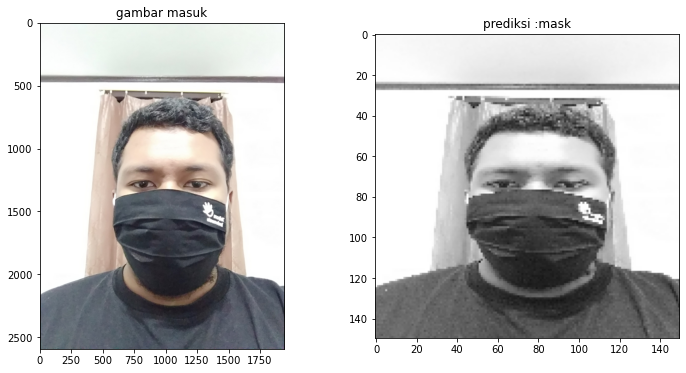

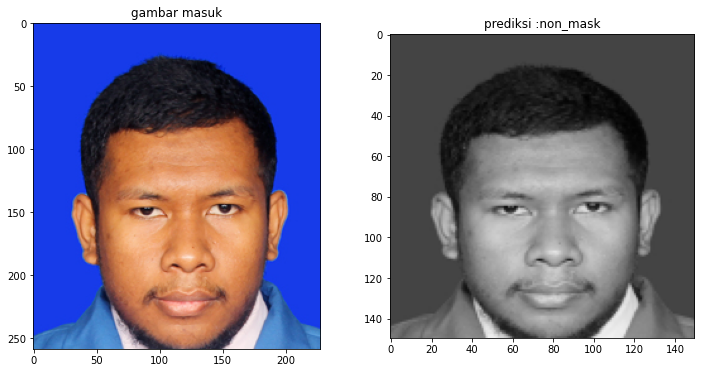

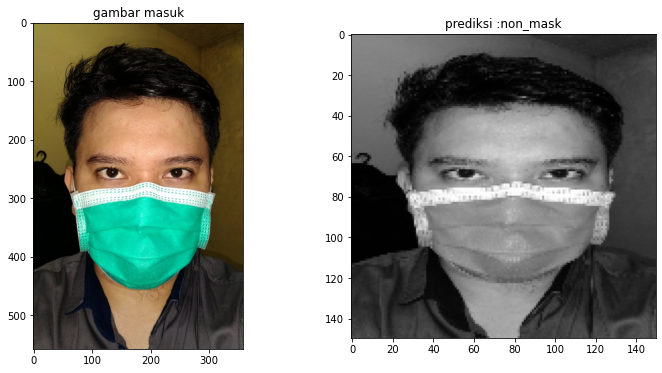

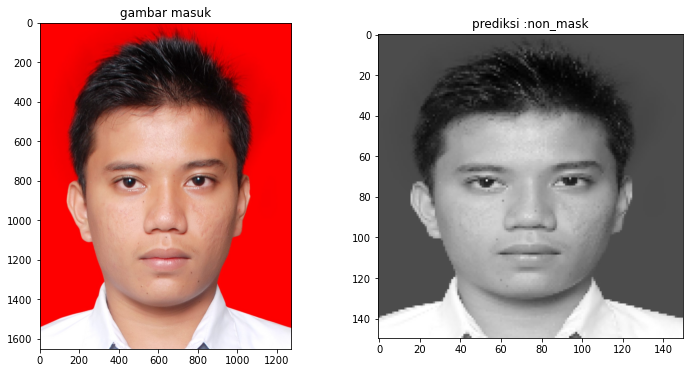

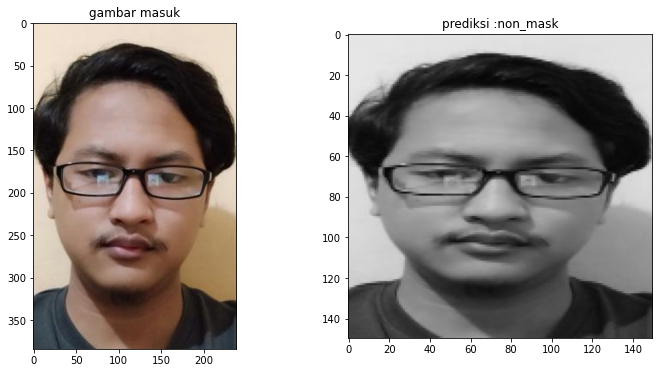

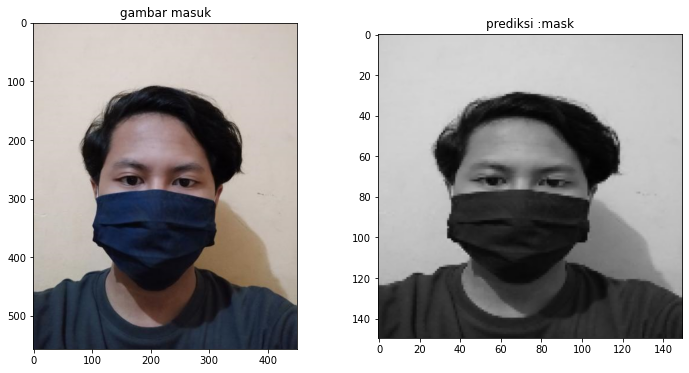

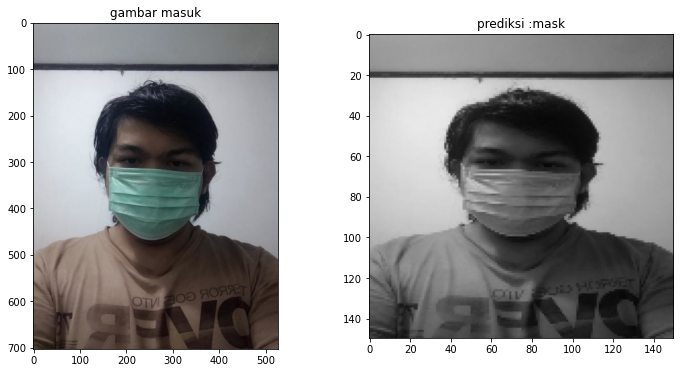

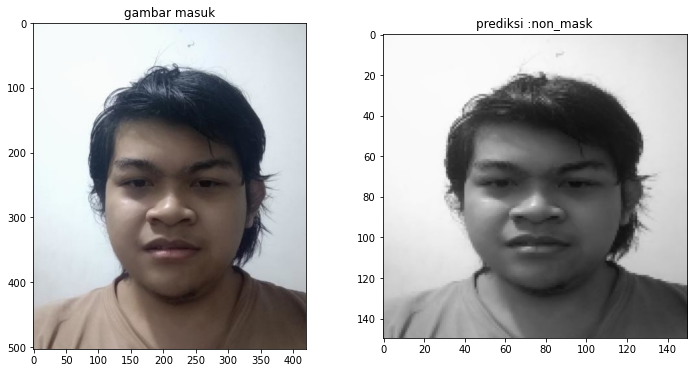

In [50]:
ip_img_folder = 'demo/'
ip_img_files = ['image_1.png','image_2.png','image_3.png','image_4.png','image_5.png','image_6.png','image_7.png','image_8.png']
scene_predicted = [scene_predict(os.path.join(ip_img_folder,img_file))for img_file in ip_img_files]